In [47]:
import pandas as pd
import requests
import zipfile
import io
import os
import csv
import ctypes as ct
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns
import QuantLib as ql

from bgs.load_bgs_amounts import load_bgs_amounts
from bgs.load_gilt_details import load_csv_blocks
from bgs.load_bgs_prices import load_prices
from bgs.gilt_analytics import gilt_yield
from bgs.linker_analytics import linker_real_yield

In [48]:
def clean_date(bgs_index):
    if re.match(r'^\d{2}\s\w{3}\s+\d{4}$', bgs_index):
        return pd.to_datetime(bgs_index, format="%d %b %Y", errors='coerce')
    else:
        return pd.to_datetime(bgs_index)

def clean_percentage(x):
    if x.strip() in ['Variable','Floating']:
        return x
    try:
        x = float(x)
    except (ValueError, TypeError):
        units, fractions = x.split(' ')
        num, denom = map(float, fractions.split('/'))
        x = float(units) + num / denom
        print(x)
    return x

### British Gilt Survey Amounts Table

In [49]:
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

conv = tables['Conventionals']
conv.replace("Redeemed", "", inplace=True)
conv = conv.apply(pd.to_numeric, errors='coerce')
conv.fillna(0, inplace=True)
conv.index = pd.Index([clean_date(x) for x in list(conv.index)]).to_period('M').to_timestamp('M')

old = tables['Calculated indexed nominal Old-style']
old.replace("Redeemed", "", inplace=True)
old = old.apply(pd.to_numeric, errors='coerce')
old.fillna(0, inplace=True)
old.index = pd.Index([clean_date(x) for x in list(old.index)]).to_period('M').to_timestamp('M')

new = tables['Calculated indexed nominal New-style']
new.replace("Redeemed", "", inplace=True)
new = new.apply(pd.to_numeric, errors='coerce')
new.fillna(0, inplace=True)
new.index = pd.Index([clean_date(x) for x in list(new.index)]).to_period('M').to_timestamp('M')

new_no_idx = tables['Index-linked New-style']
new_no_idx.replace("Redeemed", "", inplace=True)
new_no_idx = new_no_idx.apply(pd.to_numeric, errors='coerce')
new_no_idx.fillna(0, inplace=True)
new_no_idx.index = pd.Index([clean_date(x) for x in list(new_no_idx.index)]).to_period('M').to_timestamp('M')


### British Gilts Survey Month End Prices

In [50]:
price_df=load_prices("downloads/BGSPrices.csv")
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')
for text in ['Amalgamated', 'Redeemed', 'redeemed']:
    price_df = price_df.replace(text, 0)
price_df = price_df.replace('missing', None)
price_df = price_df.ffill(axis=0)
price_df = price_df.fillna(0)

/tmp/ipykernel_747/736416946.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.replace(text, 0)
/tmp/ipykernel_747/736416946.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.ffill(axis=0)


### British Gilts Survey Details Table (Bond Static Data, Coupon Maturity etc.) 

In [51]:
details = load_csv_blocks("downloads/BGSDetails.csv")

conv_details = details['Conventionals']
conv_details['%'] = conv_details['%'].apply(clean_percentage)

new_details = details['Index-Linked New-style']
new_details['%'] = new_details['%'].apply(clean_percentage)

old_details = details['Index-Linked Old-style']
old_details['%'] = old_details['%'].apply(clean_percentage)

3.75


# ONS Nominal GDP

In [52]:
# https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ybha/pn2
ons_download_ybha = "downloads/series-020925.csv"
df_ybha = pd.read_csv(ons_download_ybha, skiprows=8,names=["CDID","YBHA"])
q_start =  df_ybha.loc[df_ybha['CDID']=="1955 Q1"].index[0]
df_ybha_q = df_ybha.iloc[q_start:]
df_ybha_q['date']=df_ybha_q['CDID'].apply(lambda x: f"{x.split(' Q')[0]}-{int(x.split(' Q')[1])*3}-01")
df_ybha_q['date']=pd.to_datetime(df_ybha_q['date'], format='%Y-%m-%d')
df_ybha_q.set_index('date', inplace=True)
df_ybha_m = df_ybha_q.resample('M').ffill()
df_ybha_m.head(10)

/tmp/ipykernel_747/2043579887.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ybha_q['date']=df_ybha_q['CDID'].apply(lambda x: f"{x.split(' Q')[0]}-{int(x.split(' Q')[1])*3}-01")
/tmp/ipykernel_747/2043579887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ybha_q['date']=pd.to_datetime(df_ybha_q['date'], format='%Y-%m-%d')
/tmp/ipykernel_747/2043579887.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ybha_m = df_ybha_q.resample('M').

,CDID,YBHA
date,,
1955-03-31,1955 Q1,4666
1955-04-30,1955 Q1,4666
1955-05-31,1955 Q1,4666
1955-06-30,1955 Q2,4688
1955-07-31,1955 Q2,4688
1955-08-31,1955 Q2,4688
1955-09-30,1955 Q3,4862
1955-10-31,1955 Q3,4862
1955-11-30,1955 Q3,4862


In [53]:
# def get_ons_data(code):
#     user_agent = "econ-project/Version1.0.0 (organisation-name contact:cormach@github)"
#     url = "https://api.beta.ons.gov.uk/v1"
#     headers = {
#         "User-Agent": user_agent
#     }
#     response = requests.get(f"https://api.beta.ons.gov.uk/v1/economy/grossdomesticproductgdp/timeseries/ybha", headers=headers)
#     if response.status_code == 200:
#         return response.json()
#     else:
#         response.raise_for_status()

# r = get_ons_data("YBHA")

### ONS Net Debt (excluding public sector banks) as a % of GDP: NSA (PUSF)

In [54]:
ons_download_pusf = "downloads/series-030925.csv"
df_pusf = pd.read_csv(ons_download_pusf, skiprows=8,names=["CDID","HF6X"])
q_start =  df_pusf.loc[df_pusf['CDID']=="1975 Q1"].index[0]
q_end =  df_pusf.loc[df_pusf['CDID']=="2025 Q2"].index[0]
df_pusf_q = df_pusf.iloc[q_start:q_end].ffill()
df_pusf_q['date']=df_pusf_q['CDID'].apply(lambda x: f"{x.split(' Q')[0]}-{int(x.split(' Q')[1])*3}-01")
df_pusf_q['date']=pd.to_datetime(df_pusf_q['date'], format='%Y-%m-%d')
df_pusf_q.set_index('date', inplace=True)
df_pusf_m = df_pusf_q.resample('ME').ffill()
df_pusf_m.head(10)
df_pusf_m['HF6X'] = df_pusf_m['HF6X'].apply(lambda x: x/100)

In [55]:
df_pusf_q

,CDID,HF6X
date,,
1975-03-01,1975 Q1,47.8
1975-06-01,1975 Q2,47.8
1975-09-01,1975 Q3,47.8
1975-12-01,1975 Q4,47.8
1976-03-01,1976 Q1,49.4
...,...,...
2024-03-01,2024 Q1,95.6
2024-06-01,2024 Q2,95.8
2024-09-01,2024 Q3,95.4


In [56]:
price_df.columns = [str(x) for x in price_df.columns]

<Axes: >

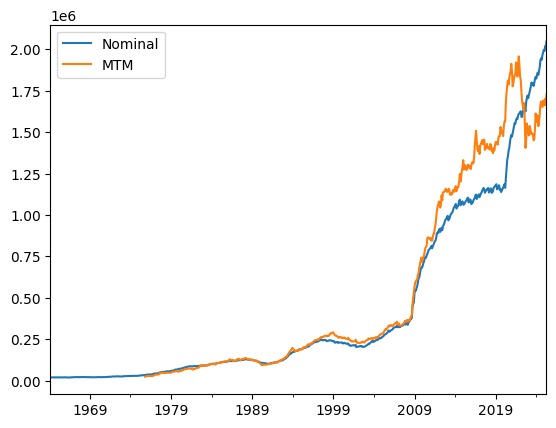

In [57]:
mtm_list = []

for bgs_gilt_id in conv.columns:
    # print(bgs_gilt_id)
    calc_df = pd.DataFrame(index=price_df.index, columns=['amounts','prices'])
    calc_df = pd.concat([conv[bgs_gilt_id],price_df[bgs_gilt_id]], join='inner', axis=1, keys=['amounts','prices'])
    calc_df['mtm'] = calc_df['amounts']*calc_df['prices']/100
    mtm_list.append(calc_df['mtm'].rename(bgs_gilt_id).copy())
#mtm_df[bgs_gilt_id] = calc_df['amounts']*calc_df['prices']
#mtm_list.append(mtm_df)
conv_mtm_df = pd.concat(mtm_list, axis=1)

conventionals = pd.DataFrame()
conventionals['Nominal'] = conv.sum(axis=1)
conventionals['MTM'] = conv_mtm_df.sum(axis=1)
conventionals.index = pd.to_datetime(conventionals.index, format="%b %Y").to_period('M').to_timestamp('M')

conventionals.plot()

<Axes: >

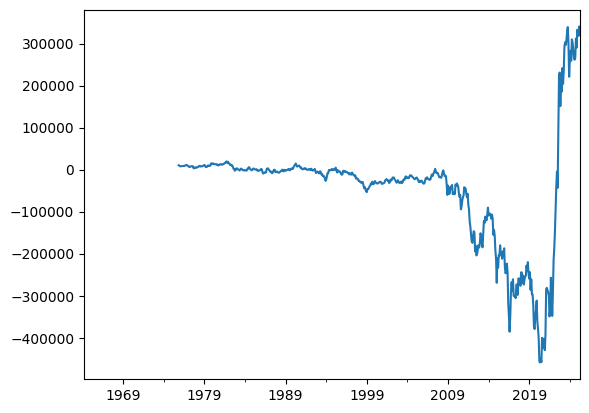

In [58]:
(conventionals['Nominal'] - conventionals['MTM']).plot()

<Axes: >

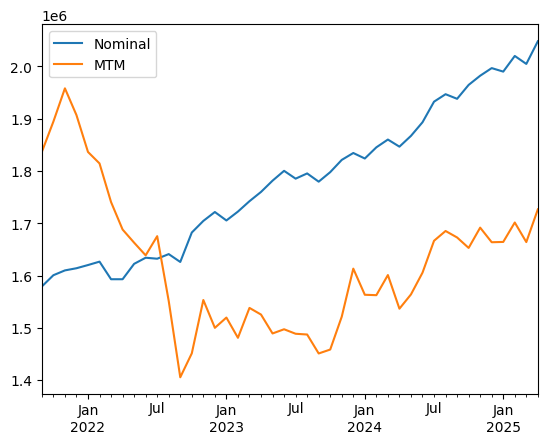

In [59]:
conventionals['2021-09-01':].plot()

In [60]:
for bgs_gilt_id in old.columns:
    # print(bgs_gilt_id)
    calc_df = pd.DataFrame(index=price_df.index, columns=['amounts','prices'])
    calc_df = pd.concat([old[bgs_gilt_id],price_df[bgs_gilt_id]], join='inner', axis=1, keys=['amounts','prices'])
    calc_df['mtm'] = calc_df['amounts']*calc_df['prices']/100
    mtm_list.append(calc_df['mtm'].rename(bgs_gilt_id).copy())

In [61]:
for bgs_gilt_id in new.columns:
    # print(bgs_gilt_id)
    calc_df = pd.DataFrame(index=price_df.index, columns=['amounts','prices'])
    calc_df = pd.concat([new[bgs_gilt_id],price_df[bgs_gilt_id]], join='inner', axis=1, keys=['amounts','prices'])
    calc_df['mtm'] = calc_df['amounts']*calc_df['prices']/100
    mtm_list.append(calc_df['mtm'].rename(bgs_gilt_id).copy())

In [62]:
total_gilts_mtm = pd.concat(mtm_list, axis=1)

total_gilts = pd.DataFrame()
total_gilts['MTM'] = total_gilts_mtm.sum(axis=1)
total_gilts.index = pd.to_datetime(total_gilts.index, format="%b %Y").to_period('M').to_timestamp('M')


In [63]:
total_nominal = tables['Sum of total conventional and indexed-linked'].reset_index().set_index('index')
total_nominal = total_nominal.drop_duplicates()
total_nominal.index = pd.Index([clean_date(x) for x in list(total_nominal.index)]).to_period('M').to_timestamp('M')

total_nominal['Sum of total conventional and indexed-linked'] = pd.to_numeric(total_nominal['Sum of total conventional and indexed-linked'])

In [64]:
total_nominal['conv']= conventionals['Nominal']

In [65]:
def before_linkers(row):
    if row['Sum of total conventional and indexed-linked'] == "":
        total_nominal =  row['conv']
    else:
        total_nominal =  row['Sum of total conventional and indexed-linked']
    return total_nominal

total_nominal['Total Nominal'] = total_nominal.apply(before_linkers, axis=1)

In [66]:
# ax = total_nominal['Sum of total conventional and indexed-linked'].plot()
# total_gilts.plot(ax = ax)
total_gilts['Nominal']=total_nominal['Total Nominal']

In [67]:
total_gilts.head()

,MTM,Nominal
1975-11-30,23289.255625,NaN
1975-12-31,25095.471250,NaN
1976-01-31,27623.461250,NaN
1976-02-29,28228.363750,NaN
1976-03-31,27367.018125,NaN


In [68]:
total_gilts = total_gilts.merge(df_ybha_m, left_index=True, right_index=True, how='inner')

In [69]:
total_gilts.tail()

,MTM,Nominal,CDID,YBHA
2024-12-31,2.245898e+06,2620691.0,2024 Q4,727199
2025-01-31,2.256886e+06,2617256.0,2024 Q4,727199
2025-02-28,2.293192e+06,2651899.0,2024 Q4,727199
2025-03-31,2.248394e+06,2641129.0,2025 Q1,738159
2025-04-30,2.314969e+06,2691295.0,2025 Q1,738159


In [70]:
total_gilts['Debt to GDP'] = total_gilts['Nominal'] / (total_gilts['YBHA'] * 4)
total_gilts['MTM to GDP'] = total_gilts['MTM'] / (total_gilts['YBHA'] * 4)

<Axes: xlabel='date'>

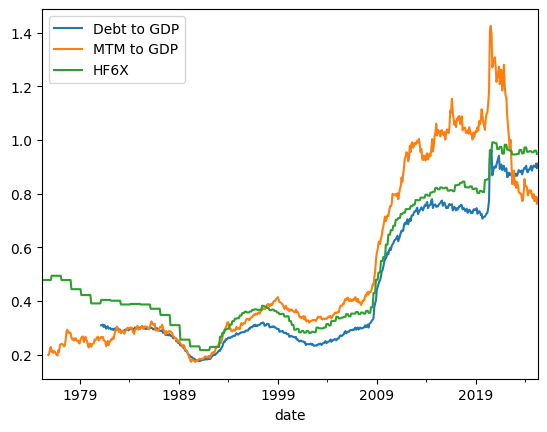

In [71]:
ax = total_gilts[['Debt to GDP','MTM to GDP']].plot()
df_pusf_m.plot(ax=ax)

<Axes: xlabel='date'>

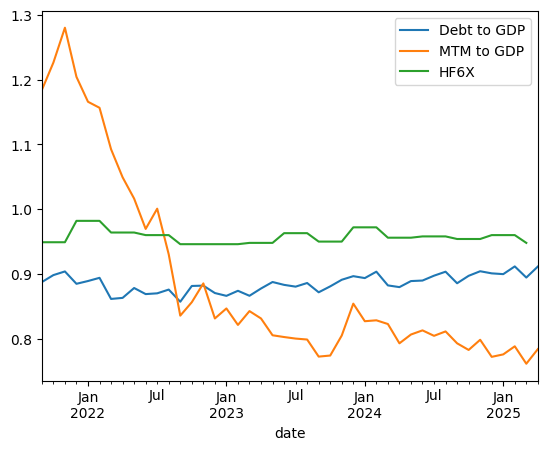

In [73]:
ax = total_gilts['2021-09-01':][['Debt to GDP','MTM to GDP']].plot()
df_pusf_m['2021-09-01':].plot(ax=ax)